**Semester Project**
----------------------------------
**Name** : *Ahmad Farhan* <br>
**Roll No.** : *i211366* <br>
**Section** : *A* <br>
__________________________________

# Time Table Scheduling Using Genetic Algorithm  

In [51]:
from bitstring import BitArray
import pandas as pd
import collections
import numpy as np
import copy

## Hard Constraint Evaluation Functions

In [52]:
'''Hard Constraint Functions'''

'• Classes can only be scheduled in free classrooms.'
def hv_free_classrooms(classes):
    violations = 0
    assigned_rooms = collections.defaultdict(list)
    # Create lists of assigned timeslots per room
    for cls in classes:
        assigned_rooms[cls.first_lecture_room].append(cls.first_lecture)
        assigned_rooms[cls.second_lecture_room].append(cls.second_lecture)
    # Each duplicate timeslot is a clash 
    for times in assigned_rooms.values():
        if len(times) != len(set(times)):
            violations += 1
    return violations

'• A classroom should be big enough to accommodate the section' 
def hv_check_room_capacity(classes):
    violations = 0
    for cls in classes:
        #  Penelty whenever section stength more than room capacity
        if sections_df[cls.section] > classrooms_df[cls.first_lecture_room].cap(): violations += 1
        if sections_df[cls.section] > classrooms_df[cls.second_lecture_room].cap(): violations += 1
    return violations


'• A professor should not be assigned two different lectures at the same time.'
def hv_professor_simul_lect(classes):
    violations = 0 
    professor_schedule = collections.defaultdict(list)
    # Create lists of timeslots assigned to each professor
    for cls in classes:
        professor_schedule[cls.professor].append(cls.first_lecture)
        professor_schedule[cls.professor].append(cls.second_lecture)
    # Each Duplicate timeslot for a professor is a clash
    for lectures in professor_schedule.values():
        if len(lectures) != len(set(lectures)):
            violations += 1
    return violations

'• The same section cannot be assigned to two different rooms at the same time.'
def hv_section_room_simul(classes):
    violations = 0
    section_schedule = collections.defaultdict(list)
    # Create lists of timeslots assigned to each section 
    for cls in classes:
        section_schedule[cls.section].append(cls.first_lecture)
        section_schedule[cls.section].append(cls.second_lecture)
        
    # Each duplicate timeslot per section is a clash 
    for section in section_schedule.values():
        if len(section) != len(set(section)):
            violations += 1
    return violations

'• A room cannot be assigned for two different sections at the same time.'
def hv_room_section_simul(classes):
    violations = 0
    room_sections = collections.defaultdict(list)
    # Create lists of all sections assigned to a room at a timeslot
    for cls in classes:# a room at a time
        room_sections[(cls.first_lecture_room,cls.first_lecture)].append(cls.section)
        room_sections[(cls.second_lecture_room,cls.second_lecture)].append(cls.section)
    # Each Duplicate Section per Room-Timeslot pair is a clash 
    for lecture in room_sections.values():
        if len(set(lecture)) > 1: violations+=1
    return violations

'• No professor can teach more than 3 courses.'
def hv_professor_course_limit(classes): 
    violations = 0
    professor_courses = collections.defaultdict(list)
    # Create lists of courses assigned to each professor
    for cls in classes: professor_courses[cls.professor].append(cls.course)
    # Count Number of unique lectures per professor
    for courses in professor_courses.values():
        if len(set(courses)) > 3: violations+=1
    return violations

'• No section can have more than 5 courses in a semester.'
def hv_section_course_limit(classes):
    violations = 0
    section_courses = collections.defaultdict(list)
    # Create lists of courses assigned to each section
    for cls in classes: section_courses[cls.section].append(cls.course)
    # Count Number of Unique Courses per Section
    for courses in section_courses.values():
        if len(set(courses)) > 5: violations+=1
    return violations

'• Each course would have two lectures per week not on the same or adjacent days.'
def hv_course_lectures_per_week(classes):
    violations = 0
    theory_courses = collections.defaultdict(list)
    # Create lists of all timeslots assigned to a section for a course
    for cls in classes:
        if(courses_df[cls.course] == 0):
            theory_courses[(cls.section,cls.course)].append((cls.first_lecture, cls.second_lecture))
    # Each Section-Course Pair assigned more than 2 lectures per week is a violation
    for cls in theory_courses.values():
        if len(cls) > 1: violations += 1    # Checking (first_lecture,second_lecture) pairs
        # Count Number of days b/w first_lecture and second_lecture, < 2 is same or adjacent days
        elif len(cls) == 1 and abs(timeslots_df[cls[0][0]].day-timeslots_df[cls[0][1]].day) < 2:
            violations+=1
    return violations

'• Lab lectures should be conducted in two consecutive slots.'
def hv_consequtive_lab_slots(classes):
    violations = 0
    lab_courses = collections.defaultdict(list)
    # Create lists of all Lab Lectures i.e., course.type == 1
    for cls in classes:
        if(courses_df[cls.course] == 1):
            lab_courses[(cls.section,cls.course)].append((cls.first_lecture, cls.second_lecture))
    # Each Section-Course Pair assigned more than 2 lab sessions per week is a violation
    # Check timeslots are adjecent and on the same days 
    for cls in lab_courses.values():
        if len(cls) > 1: violations += 1
        elif len(cls) == 1 and (abs(cls[0][0] - cls[0][1]) != 1 or \
        timeslots_df[cls[0][0]].day != timeslots_df[cls[0][1]].day): 
            violations+=1
    return violations

'• 15 mins breaks allowed between consecutive classes to ensure that there is sufficient time for transitions between classes.'
def hv_15minute_class_breaks(classes):
    violations = 0
    theory_lectures = collections.defaultdict(list)
    # Create lists of all timeslots assigned to a section for a course
    for cls in classes:
        if courses_df[cls.course] == 0:
            theory_lectures[cls.course].append(cls.first_lecture)
            theory_lectures[cls.course].append(cls.second_lecture)

    # Each Section-Course Pair assigned more than 2 lectures per week is a violation
    for cls in theory_lectures.values():
        # Count Number of days b/w first_lecture and second_lecture, < 2 is same or adjacent days
        if len(cls) == 1 and abs(timeslots_df[cls[0][0]].time-timeslots_df[cls[0][1]].time) < 15:
            violations+=1
    return violations

## Soft Constraint Evaluation Functions

In [53]:
'''Soft Constraint Functions'''
sv_weight = 5   # Maximum Soft constraint violation value per constraint
'• A class should be held in the same classroom across the whole week.'
def sv_same_room_classes(classes):
    violations = 0
    for cls in classes:
        # Check if lecture rooms of both lectures are same
        if cls.first_lecture_room != cls.second_lecture_room: violations+=1
    return round(violations/len(classes)*sv_weight)

# Create list of timeslots of Lab/Theory Courses
def get_lectures(classes, type):
    type_schedule = []
    type_id = 0 if type == 'lab' else 1
    for cls in classes:
        if courses_df[cls.course] == type_id:
            type_schedule.append(cls.first_lecture)
            type_schedule.append(cls.second_lecture)
    return type_schedule
    
'• All the theory classes in the morning session and all the lab classes done in the afternoon session.'
def sv_lecture_sessions(classes):
    violations = 0
    # Get lists of all timeslots of all theory courses 
    theory_lectures = get_lectures(classes, 'theory')
    for lecture in theory_lectures:
        # Check if timeslot is in Morning session
        time_hour = int(timeslots_df[lecture].time)
        if time_hour >= 1430 and time_hour <= 1700:
            violations += 1
    
    # Get lists of all timeslots of all theory courses 
    lab_lectures = get_lectures(classes, 'lab')
    for lecture in lab_lectures:
        # Check if timeslot is in Morning session
        time_hour = int(timeslots_df[lecture].time)
        if not(time_hour >= 1430 and time_hour <= 1700):
            violations += 1
    return round(violations/(len(lab_lectures)+len(theory_lectures))*sv_weight)

'• Teachers/students may be facilitated by minimizing the number of floors they have to traverse.'
def sv_same_floor_lectures(classes):
    violations = 0
    # Create lists of all room floors assigned to each professor
    # Create lists of all room floors assigned to each section
    professor_schedule = collections.defaultdict(list)
    section_schedule = collections.defaultdict(list)
    for cls in classes:
        professor_schedule[cls.professor].append(classrooms_df[cls.first_lecture_room].floor)
        section_schedule[cls.section].append(classrooms_df[cls.first_lecture_room].floor)
        professor_schedule[cls.professor].append(classrooms_df[cls.second_lecture_room].floor)
        section_schedule[cls.section].append(classrooms_df[cls.second_lecture_room].floor)
    # Number of Unique floors per section/professor not 1 is a violation
    for section_floors in section_schedule.values():
        if (len(set(section_floors)) != 1): violations+=1
    for prof_floors in professor_schedule.values():
        if (len(set(prof_floors)) != 1): violations+=1
    return round(violations/(len(section_schedule)+len(professor_schedule))*sv_weight)

'• Teachers prefer longer blocks of continuous teachingexcept when the courses are different.'
def sv_professor_lecture_block(classes):
    violations=0
    professor_schedule = collections.defaultdict(list)
    # Create lists of all timeslots assigned to a professor for a course
    for cls in classes:
        professor_schedule[(cls.professor,cls.course)].append(cls.first_lecture)
        professor_schedule[(cls.professor,cls.course)].append(cls.second_lecture)

    # Max slot - Min slot should be number of slots assigned per day
    for cls_times in professor_schedule.values():
        if max(cls_times) - min(cls_times) != len(cls_times)-1:
            violations+=1
    return round(violations/len(professor_schedule)*sv_weight)

In [54]:
class Timeslot:
    def __init__(self, day, time) -> None:
        self.day = day
        self.time = time
    def __str__(self) -> str:
        return f"Day: {self.day}, Time: {self.time}"
    
class Room:
    def __init__(self, room_type, floor=None) -> None:
        self.type = room_type
        self.floor = floor
    def __str__(self) -> str:
        return "Classroom" if self.type == 0 else "Lecture Hall" 
    def cap(self) -> int:
        return 60 if self.type == 0 else 120
    
def generate_two_points(length):
    point1 = np.random.randint(0, length - 1)
    point2 = np.random.randint(0, length - 1)
    while point2 == point1:
        point2 = np.random.randint(0, length - 1)
    return min(point1, point2), max(point1, point2)

hard_constraints = [
'1. Classes can only be scheduled in free classrooms.'
'2. A classroom should be big enough to accommodate the section. There should be two categories of classrooms: classroom (60) and large hall (120).'
'3. A professor should not be assigned two different lectures at the same time.'
'4. The same section cannot be assigned to two different rooms at the same time.'
'5. A room cannot be assigned for two different sections at the same time.'
'6. No professor can teach more than 3 courses.'
'7. No section can have more than 5 courses in a semester.'
'8. Each course would have two lectures per week not on the same or adjacent days.'
'9. Lab lectures should be conducted in two consecutive slots.'
'10. 15 mins breaks allowed between consecutive classes to ensure that there is sufficient time for transitions between classes.'
]

soft_constraints = [
'1. All the theory classes should be taught in the morning session and all the lab sessions should be done in the afternoon session.'
'2. Teachers/students may be facilitated by minimizing the number of floors they have to traverse. That is, as much as possible, scheduled classes should be on the same floor for either party.'
'3. A class should be held in the same classroom across the whole week.'
'4. Teachers may prefer longer blocks of continuous teaching time to minimize interruptions and maximize productivity except when the courses are different.'
]

### Binary Encoded Gene Class

In [55]:
'''
Defined By field_bits: Variable Bits per field 
----------------------------------------------
course = 4 bits: Max 16 courses
section = 4 bits: Max 16 courses
professor = 4 bits: Max 16 profs
first_lecture: 5 bits: Max 32 Timeslots
first_lecture_room: 3 bits: Max 8 rooms
second_lecture: 5 bits: Max 32 Timeslots
second_lecture_room: 3 bits: Max 8 rooms
'''          # Indices
n_courses = 4   #0
n_sections = 4    #1
n_professors = 4     #2  
n_first_lecture = 5     #3
n_first_lecture_room = 4  #4
n_second_lecture = 5        #5
n_second_lecture_room = 4   #6

# List of bits per attribute field of gene
field_bits = [n_courses,n_sections,n_professors,n_first_lecture,
    n_first_lecture_room,n_second_lecture,n_second_lecture_room]
n_bits = sum(field_bits)    # Total bits per gene
print(f"Bits per Gene : {n_bits}, Distributed as: {field_bits}")

def attrs_to_bits(attributes) -> list:
    # Converts list of int attributes to list of binary attributes defined by BitArray
    return [BitArray('0b' + bin(attr)[2:].zfill(bits)) for attr,bits in zip(attributes,field_bits)] 

def data_to_bits(course:int, section:int, professor:int, 
                first_lecture:int, first_lecture_room:int,
                second_lecture:int, second_lecture_room:int) -> list:
    # Adapter that converts int fields to list of binary attributes
    fields = [course, section, professor, first_lecture, first_lecture_room, second_lecture, second_lecture_room]
    return attrs_to_bits(fields)

class BinClass:
    '''Binary Encoded Representation of Gene'''
    def __init__(self,course:int, section:int, professor:int, 
                first_lecture:int, first_lecture_room:int,
                second_lecture:int, second_lecture_room:int) -> None:
        # Convert integer attribute values into binary codes
        bin_attributes = data_to_bits(course,section,professor,first_lecture,
                        first_lecture_room,second_lecture, second_lecture_room)
        self._course = bin_attributes[0]     # id indexing courses_df list
        self._section = bin_attributes[1]      # id indexing sections_df list
        self._professor = bin_attributes[2]      # id indexing professors_df list
        self._first_lecture = bin_attributes[3]    # id indexing timeslots_df(time,day) list
        self._second_lecture = bin_attributes[5]     # id indexing timeslots_df(time,day) list
        self._first_lecture_room = bin_attributes[4]   # id indexing classrooms_df list
        self._second_lecture_room = bin_attributes[6]    # id indexing classrooms_df list
        
    @property # int value of course binary 
    def course(self): return self._course.uint
    @property # int value of section binary
    def section(self): return self._section.uint
    @property # int value of professor binary
    def professor(self): return self._professor.uint
    @property # int value of first_lecture binary
    def first_lecture(self): return self._first_lecture.uint
    @property # int value of first_lecture_room binary
    def first_lecture_room(self): return self._first_lecture_room.uint
    @property # int value of first_lecture binary
    def second_lecture(self): return self._second_lecture.uint
    @property # int value of second_lecture_room binary
    def second_lecture_room(self): return self._second_lecture_room.uint
    
    def __str__(self) -> str:
        return f"Class(course:{self.course}, section:{self.section}, professor:{self.professor}, first_lecture:{self.first_lecture}, first_lecture_room:{self.first_lecture_room}, second_lecture:{self.second_lecture}, second_lecture_room:{self.second_lecture_room}"

Bits per Gene : 30, Distributed as: [4, 4, 4, 5, 4, 5, 4]


In [56]:
class Class:
    '''Integer Encoded Representation of Gene'''
    def __init__(self,course:int=None, section:int=None, professor:int=None, 
                first_lecture:int=None, first_lecture_room:int=None,
                second_lecture:int=None, second_lecture_room:int=None) -> None:
        
        self.course = course            # id indexing courses_df list
        self.section = section             # id indexing sections_df list
        self.professor = professor            # id indexing professors_df list
        self.first_lecture = first_lecture       # id indexing timeslots_df(time,day) list
        self.second_lecture = second_lecture        # id indexing timeslots_df(time,day) list
        self.first_lecture_room = first_lecture_room   # id indexing classrooms_df list
        self.second_lecture_room = second_lecture_room    # id indexing classrooms_df list

    def __str__(self) -> str:
        return f"Class(course:{self.course}, section:{self.section}, professor:{self.professor}, first_lecture:{self.first_lecture}, first_lecture_room:{self.first_lecture_room}, second_lecture:{self.second_lecture}, second_lecture_room:{self.second_lecture_room})"

In [57]:
class Schedule:
    '''Chromosome Representing Schedule of Entire Week'''
    def __init__(self, classes:list) -> None:
        self.classes = classes
        self.fitness_val = self.fitness()
    
    def __str__(self) -> str:
        return ' '.join(str(cls.course) for cls in self.classes)

    def __disp__(self) -> str:
        return '\n'.join(str(cls) for cls in self.classes)

    def fitness(self) -> int:
        '''Objective Function to calculate fitness'''
        hard_violations = 0; soft_violations = 0

        'Hard Constraints'
        '• Classes can only be scheduled in free classrooms.'
        hard_violations += hv_free_classrooms(self.classes)
        '• A classroom should be big enough to accommodate the section. classroom (60) and large hall (120).'
        hard_violations += hv_check_room_capacity(self.classes)
        '• A professor should not be assigned two different lectures at the same time.'
        hard_violations += hv_professor_simul_lect(self.classes)
        '• The same section cannot be assigned to two different rooms at the same time.'
        hard_violations += hv_section_room_simul(self.classes)
        '• A room cannot be assigned for two different sections at the same time.'
        hard_violations += hv_room_section_simul(self.classes)
        '• No professor can teach more than 3 courses.'
        hard_violations += hv_professor_course_limit(self.classes)
        '• No section can have more than 5 courses in a semester.'
        hard_violations += hv_section_course_limit(self.classes)
        '• Each course would have two lectures per week not on the same or adjacent days.'
        hard_violations += hv_course_lectures_per_week(self.classes)
        '• Lab lectures should be conducted in two consecutive slots.'
        hard_violations += hv_consequtive_lab_slots(self.classes)
        '• 15 mins breaks allowed between consecutive classes to ensure that there is sufficient time for transitions between classes.'
        hard_violations += hv_15minute_class_breaks(self.classes)

        'Soft Constraints'
        '• A class should be held in the same classroom across the whole week.'
        soft_violations += sv_same_room_classes(self.classes)
        '• All theory classes taught in the morning session and all the lab sessions done in the afternoon session.'
        soft_violations += sv_lecture_sessions(self.classes)
        '• Minimize the number of floors Teachers/students traverse. Scheduled classes on the same floor for either party.'
        soft_violations += sv_same_floor_lectures(self.classes)
        '• Teachers may prefer longer blocks of continuous teaching time except when the courses are different.'
        soft_violations += sv_professor_lecture_block(self.classes)
        
        # Best fitness when no hard violations
        # Assign less weight to Soft Constraints
        # if hard_violations == 0: return hard_violations
        return -round(hard_violations + 0.4 * soft_violations)

    def chkconstraints(self) -> None:
        print("Hard Constraint Violations")
        print('-----------------------------------------')
        print('Classes only in Free Classrooms :', hv_free_classrooms(self.classes))
        print('Class Capacity Accomodates Section :', hv_check_room_capacity(self.classes))
        print('Professor Given Two Lectures at once :', hv_professor_simul_lect(self.classes))
        print('Section Given Two Rooms at once :', hv_section_room_simul(self.classes))
        print('Room Given Two Sections at once :', hv_room_section_simul(self.classes))
        print('Maximum 3 Courses per Professor :', hv_professor_course_limit(self.classes))
        print('Maximum 5 Courses per Section :', hv_section_course_limit(self.classes))
        print('Two Course Lectures per week :', hv_course_lectures_per_week(self.classes))
        print('Two Consequtive Slots for Labs :', hv_consequtive_lab_slots(self.classes))
        print('15 Minute Breaks b/w Classes :', hv_15minute_class_breaks(self.classes))

        print("\nSoft Constraint Violations")
        print('-----------------------------------------')
        print('Class in Same Classroom :', sv_same_room_classes(self.classes))
        print('Courses in Morning/Afternoon :', sv_lecture_sessions(self.classes))
        print('Same Floor Schedule :', sv_same_floor_lectures(self.classes))
        print('Continuous Lecture Blocks :', sv_professor_lecture_block(self.classes))

## Load Visualization/Interpretation Data

In [58]:
timeslots_data = pd.read_csv('Datasets/timeslots.csv')
classrooms_data = pd.read_csv('Datasets/classrooms.csv')
sections_data = pd.read_csv('Datasets/sections.csv')
professors_data = pd.read_csv('Datasets/professors.csv')
courses_data = pd.read_csv('Datasets/courses.csv')
days_data = ['Monday','Tuesday','Wednesday','Thursday','Friday']

# Initialize Gene Attribtue Data lists
timeslots_df = [Timeslot(int(row['day']), int(row['time'])) for _, row in timeslots_data.iterrows()]
classrooms_df = [Room(int(row['type']),int(row['floor'])) for _,row in classrooms_data.iterrows()]
sections_df = [int(row['cap']) for _,row in sections_data.iterrows()]
professors_df = list(range(len(professors_data)))
courses_df = [int(row['type']) for _,row in courses_data.iterrows()]

print("Total Available Slots:", len(timeslots_df))
print("Total Classrooms:", len(classrooms_df))
print("Total Professors:", len(professors_df))
print("Total Sections:", len(sections_df))
print("Total Courses:", len(courses_df))

Total Available Slots: 30
Total Classrooms: 16
Total Professors: 15
Total Sections: 10
Total Courses: 22


## Genetic Algorithm Functions

In [59]:
# Generates a single random gene
def generate_gene() -> Class:
    crse = np.random.randint(0,len(courses_df))
    sctn = np.random.randint(0,len(sections_df))
    prfs = np.random.randint(0,len(professors_df))
    fstl = np.random.randint(0,len(timeslots_df))
    sndl = np.random.randint(0,len(timeslots_df))
    fstr = np.random.randint(0,len(classrooms_df))
    sndr = np.random.randint(0,len(classrooms_df))
    return Class(crse,sctn,prfs,fstl,fstr,sndl,sndr)    # Use for integer encoded Gene
    # return BinClass(crse,sctn,prfs,fstl,fstr,sndl,sndr) # Use for binary encoded Gene

# Generate a Single Chromosome
def generate_chromosome(n_size:int) -> list:
    return Schedule([generate_gene() for _ in range(n_size)])

# Generated Initial Population
def generate_initial_pop(n_pop:int, n_size:int) -> list:
    return [generate_chromosome(n_size) for _ in range(n_pop)]

In [60]:
# Single Point Crossover
def crossover(parent1:Schedule, parent2:Schedule, r_cross:float=0.95) -> list:
    c1 = copy.deepcopy(parent1.classes) 
    c2 = copy.deepcopy(parent2.classes)
    if(np.random.rand() < r_cross):
        # Split and swap sectinos at random index of classes
        k_pt = np.random.randint(0,len(parent1.classes)-2)
        c1 = parent1.classes[:k_pt] + parent2.classes[k_pt:]
        c2 = parent2.classes[:k_pt] + parent1.classes[k_pt:]
    return [Schedule(c1), Schedule(c2)]

# Two Point Crossover
def crossover2(parent1:Schedule, parent2:Schedule, r_cross:float=0.95) -> list:
    c1 = copy.deepcopy(parent1.classes) 
    c2 = copy.deepcopy(parent2.classes)
    if(np.random.rand() < r_cross):
        # Pick two points and swap the intermediate section
        k1_pt,k2_pt = generate_two_points(len(parent1.classes)-2)
        c1[k1_pt:k2_pt] = parent2.classes[k1_pt:k2_pt]
        c2[k1_pt:k2_pt] = parent1.classes[k1_pt:k2_pt]
    return [Schedule(c1), Schedule(c2)]

# Uniform Crossover
def crossover3(parent1:Schedule, parent2:Schedule, r_cross:float=0.95) -> list:
    c1 = copy.deepcopy(parent1.classes) 
    c2 = copy.deepcopy(parent2.classes)
    if(np.random.rand() < r_cross):
        for i in range(len(parent1.classes)):
            if np.random.rand() < 0.5:
                i,j = np.random.randint(0,len(parent1.classes),2)
                c1[i],c2[j] = c2[i],c1[j]
    return [Schedule(c1), Schedule(c2)]

# Entire Chromosome Mutated
def mutation(schedule:Schedule,r_mut:float=0.2) -> Schedule:
    if np.random.rand() < r_mut:
        schedule = generate_chromosome(len(schedule.classes))
    return schedule

# Mutate individual genes
def mutation2(schedule:Schedule,r_mut:float=0.4) -> Schedule:
    for i in range(len(schedule.classes)):
        if np.random.rand() < r_mut:
            schedule.classes[i] = generate_gene()
    schedule.fitness_val = schedule.fitness()
    return schedule

record,average=None,None
# Update best fitness and corresponding individual
def update_best(pop:int,n_pop:int,best:int,best_eval:int,gen:int) -> tuple[Schedule,int]:
    for i in range(n_pop):  # Check entire population for better solutions
        if pop[i].fitness_val > best_eval:
            best,best_eval = copy.deepcopy(pop[i]), pop[i].fitness_val
            print(f"> {gen}, new best {pop[i]} = {pop[i].fitness_val}")
            record.append(best)
    return best, best_eval

# Rank-Based Selection
def selection2(population:list[Schedule]) -> Schedule:
    total_rank = sum(range(1, len(population) + 1))
    # Assign each individual a Rank based Probability 
    ranked_population = sorted(population, key=lambda x: x.fitness_val, reverse=True)
    selection_probs = [i / total_rank for i in range(1, len(population) + 1)]
    selected_index = np.random.choice(range(len(population)), p=selection_probs)
    # Pick an individual based on its probability of being picked
    return ranked_population[selected_index]

# Tournament Selection
def selection(population:list[Schedule], k:int=2) -> Schedule:
    # Pick random set of individuals and select one with best fitness
    selection_ix = np.random.randint(len(population))
    for ix in np.random.randint(0, len(population), k-1):
        if population[ix].fitness_val > population[selection_ix].fitness_val:
            selection_ix = ix
    return population[selection_ix]

# Genetic Algorithm Core Loop
def genetic_algorithm(n_iter:int, n_pop:int, r_cross:float, r_mut:float, n_slots:int=15):
    pop = generate_initial_pop(n_pop,n_slots)                                   # Generate Initial Population
    best, best_eval = 0, pop[0].fitness_val                                     # Initialize best solution
    for gen in range(n_iter):                                                   # Iterate for n_iter generations
        best,best_eval = update_best(pop, n_pop, best, best_eval, gen)          # Update best solution 
        average.append(-sum(obj.fitness_val for obj in pop)/n_pop)              # Track average Population Fitness
        selected = [selection(pop) for _ in range(n_pop)]                       # Perform Parent Selection
        children = list()
        for i in range(0,n_pop,2):
            p1,p2 = selected[i], selected[i+1]
            for c in crossover(p1,p2,r_cross):                                 # Apply Crossover
                children.append(mutation(c,r_mut))                              # Apply Mutation
        pop = children
        if best_eval == 0: break
    print("Stopped at Generation: ", gen)
    return best, best_eval

In [61]:
average = []; record = []
# Executing Genetic Algorithm
best_encoded, eval = genetic_algorithm(3000, 50, 0.95, 0.2, len(courses_df))
print(f"\nBest Chromosome: {best_encoded} = {eval}")
print("Verifying Constraint Satisfaction of Solution")

> 0, new best 13 9 10 16 1 4 16 19 10 18 5 18 0 20 2 18 8 21 5 18 3 1 = -37
> 0, new best 13 1 13 19 12 2 19 10 5 21 17 9 8 14 14 13 15 13 2 15 1 5 = -35
> 0, new best 5 11 13 9 11 9 1 7 17 9 11 4 10 4 11 16 7 20 1 10 6 3 = -32
> 0, new best 8 21 9 10 21 17 18 5 14 5 11 13 20 0 8 19 17 17 4 14 11 19 = -27
> 6, new best 9 18 16 8 6 4 13 15 5 13 14 0 16 0 7 13 15 13 16 15 21 5 = -26
> 7, new best 9 18 16 8 6 4 13 15 5 13 14 0 16 0 16 11 16 5 4 3 10 9 = -24
> 9, new best 20 18 16 8 6 4 13 15 5 13 14 0 16 0 16 11 16 15 7 5 6 7 = -23
> 11, new best 20 19 13 8 6 4 13 15 5 13 14 0 8 14 14 13 0 15 7 5 6 7 = -22
> 16, new best 9 18 16 8 6 4 2 7 5 13 14 0 8 14 14 13 0 15 7 5 6 7 = -21
> 18, new best 20 19 13 8 6 4 2 15 5 13 14 0 8 14 14 13 21 15 7 5 6 7 = -18
> 27, new best 9 19 13 8 9 4 2 15 5 13 14 0 8 17 9 10 21 15 13 5 6 7 = -17
> 27, new best 9 18 16 8 10 4 2 15 5 13 14 0 8 17 9 10 21 15 7 5 6 7 = -16
> 208, new best 8 10 13 8 10 4 2 15 5 13 14 0 8 17 9 10 21 15 7 5 6 7 = -15
> 231, new bes

In [65]:
best_encoded.chkconstraints()

Hard Constraint Violations
-----------------------------------------
Classes only in Free Classrooms : 0
Class Capacity Accomodates Section : 1
Professor Given Two Lectures at once : 0
Section Given Two Rooms at once : 0
Room Given Two Sections at once : 0
Maximum 3 Courses per Professor : 0
Maximum 5 Courses per Section : 0
Two Course Lectures per week : 1
Two Consequtive Slots for Labs : 0
15 Minute Breaks b/w Classes : 0

Soft Constraint Violations
-----------------------------------------
Class in Same Classroom : 4
Courses in Morning/Afternoon : 3
Same Floor Schedule : 4
Continuous Lecture Blocks : 5


## Visualizing Average Population Fitness

Minimum Average Population Fitness: 
Generation: 1964, Value: 11.22

Encoded Best Solution: 
Class(course:8, section:0, professor:11, first_lecture:12, first_lecture_room:14, second_lecture:5, second_lecture_room:14)
Class(course:10, section:8, professor:8, first_lecture:4, first_lecture_room:7, second_lecture:16, second_lecture_room:3)
Class(course:13, section:2, professor:1, first_lecture:26, first_lecture_room:14, second_lecture:1, second_lecture_room:8)
Class(course:8, section:3, professor:8, first_lecture:18, first_lecture_room:1, second_lecture:10, second_lecture_room:9)
Class(course:10, section:4, professor:12, first_lecture:4, first_lecture_room:8, second_lecture:29, second_lecture_room:10)
Class(course:10, section:7, professor:9, first_lecture:6, first_lecture_room:8, second_lecture:25, second_lecture_room:2)
Class(course:2, section:1, professor:5, first_lecture:23, first_lecture_room:4, second_lecture:8, second_lecture_room:6)
Class(course:15, section:6, professor:2, first_le

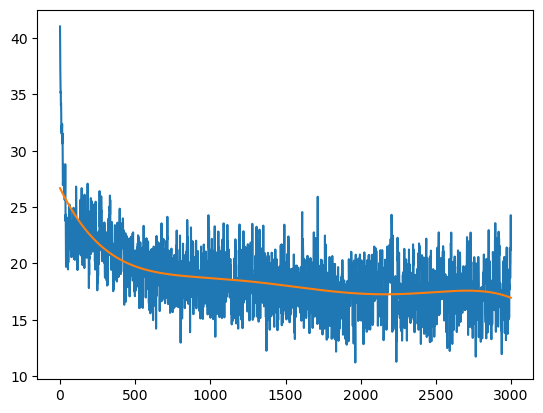

In [66]:
import matplotlib.pyplot as plt
x_values = np.arange(len(average))
print("Minimum Average Population Fitness: ")
print(f"Generation: {np.argmin(average)}, Value: {min(average)}")
print("\nEncoded Best Solution: ")
for cls in record[-1].classes: print(cls)

degree = 5
coefficients = np.polyfit(x_values, average, degree)
polynomial = np.poly1d(coefficients)
y_values = polynomial(x_values)
plt.plot(average)
plt.plot(y_values)
plt.show()

## Visualizing Best Solution

In [67]:
schedule = best_encoded

professor_names=[]
classroom_names=[]
timeslot_names=[]
section_names=[]
course_codes=[]
day_names=[]

for lecture in schedule.classes:
    course_codes.append(courses_data.course[lecture.course])
    professor_names.append(professors_data.name[lecture.professor])
    section_names.append(sections_data.section[lecture.section])
    timeslot_names.append(timeslots_data.time[lecture.first_lecture])
    day_names.append(timeslots_data.day[lecture.first_lecture])
    classroom_names.append(classrooms_data.code[lecture.first_lecture_room])

    course_codes.append(courses_data.course[lecture.course])
    professor_names.append(professors_data.name[lecture.professor])
    section_names.append(sections_data.section[lecture.section])
    timeslot_names.append(timeslots_data.time[lecture.second_lecture])
    day_names.append(timeslots_data.day[lecture.second_lecture])
    classroom_names.append(classrooms_data.code[lecture.second_lecture_room])

schedule_df = pd.DataFrame({
    "Section": section_names,
    "Course Code": course_codes,
    "Professor": professor_names,
    "Time Slot": timeslot_names,
    "Day": day_names
}, index=classroom_names)

schedule_df.sort_values(by=['Day','Time Slot'],inplace=True)
schedule_days = schedule_df['Day'].values
schedule_df['Day'] = [days_data[day_num] for day_num in schedule_days] 
schedule_df.head(len(course_codes))

,Section,Course Code,Professor,Time Slot,Day
C204,DS-B,MG220,Arshad Islam,830,Monday
C403,DS-C,CS302,Shehreyar Rashid,830,Monday
C203,CS-C,DS301,Umair Arshad,1005,Monday
C401,CS-D,CS220,Ejaz Ahmed,1005,Monday
C405,DS-A,MT224,Naveed Ahmad,1140,Monday
C401,AI-B,MG220,Ayesha Bano,1140,Monday
C204,CS-A,AI201,Sidra Khalid,1315,Monday
C305,CS-B,CS219,Naveed Ahmad,1315,Monday
C202,DS-C,CS307,Ejaz Ahmed,1450,Monday
C203,AI-A,CS307,Arshad Islam,1450,Monday
